In [27]:
import farsiteutils_v2 as futils
import pandas as pd
import geopandas as gpd

from shapely.geometry import MultiPolygon
from matplotlib import pyplot as plt
import numpy as np

SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

def change_username_jovyan(df, column):
    for ix, row in df.iterrows():
        path_list = row[column].split('/')
        path_list[2] = 'jovyan'

        path = ''
        for string in path_list[:-1]:
            path += f'{string}/'
        path += path_list[-1]

        df.loc[ix, column] = path
        
class Database:
    def __init__(self, fp: futils.FilePaths):
        # Setup params
        self.fp = fp
        
        # TODO
        # Setup the database for reading
        
        
        try:
            dftable = pd.read_pickle(self.fp.dfpath)
            change_username_jovyan(dftable, 'filepath')
        except FileNotFoundError:
            print(f'\n!!Caution!! Path {self.fp.dfpath} not found! Cannot choose ignition!!\n')
            raise
            
        # Collect the tables in dataframe format
        # Table 1 - ignition
        self.dfObservationAll = dftable[dftable['filetype'] == 'Observation']
        
        # Table 2 - barrier
        self.dfBarrier = dftable[dftable['filetype'] == 'Barrier'][['filetype', 'filepath']]
        # Table 3 - landscape
        self.dfLandscapeAll = dftable[dftable['filetype'] == 'Landscape'][['filetype', 'filepath', 'description']]
        # Table 4 - simulation
        self.dfsimulation = pd.DataFrame()
        
        self.filter_selection('Maria2019')
        
    def filter_selection(self, description):
        self.dfObservation = self.dfObservationAll[self.dfObservationAll['description'] == description]
        self.dfLandscape = self.dfLandscapeAll[self.dfLandscapeAll['description'] == description]
        
    def create_rundir(self):
        return self.fp.create_rundir()    
    
    def append(self, data: dict):
        filetype = data['filetype']
        
        if filetype == 'Simulation':
            # Read the output simulation geoms
            if os.path.exists(data['filepath']):
                gdf = gpd.read_file(data['filepath'])
                idxlst = []
                geomlst = []
                igniteidxlst = []
                compareidxlst = []
                descriptionlst = []
                datetimelst = []
                filepathlst = []
                windspeedlst = []
                winddirectionlst = []
                configpathlst = []

                # For each elapsed time
                minuteslst = gdf['Elapsed_Mi'].unique()

                for minutespassed in minuteslst:
                    gdf0 = gdf[gdf['Elapsed_Mi'] == minutespassed]
                    polygon_lst = [Polygon(value) for value in gdf0['geometry'].values]
                    multipoly = MultiPolygon()
                    for poly in polygon_lst:
                        multipoly = multipoly.union(poly.buffer(0))
                    geomlst.append(multipoly)

                    # unique id
                    uniqueid = uuid.uuid4().hex
                    idxlst.append(uniqueid)

                    igniteidxlst.append(data['igniteidx'])
                    compareidxlst.append(data['compareidx'])
                    descriptionlst.append(data['description'])
                    datetimelst.append(data['startdt'] + datetime.timedelta(minutes=minutespassed))
                    filepathlst.append(data['filepath'])
                    windspeedlst.append(data['windspeed'])
                    winddirectionlst.append(data['winddirection'])
                    configpathlst.append(data['configpath'])

                # Create the gdf for appending
                gdfappend = gpd.GeoDataFrame({'igniteidx': igniteidxlst,
                                              'compareidx': compareidxlst,
                                              'description': descriptionlst,
                                              'datetime': datetimelst,
                                              'filepath': filepathlst,
                                              'windspeed': windspeedlst,
                                              'winddirection': winddirectionlst,
                                              'configpath': configpathlst},
                                         geometry=geomlst,
                                         index=idxlst,
                                         crs=self.gdfignition.crs)
                self.gdfsimulation = pd.concat([self.gdfsimulation,
                                                gdfappend])
        else:
            print(f'filetype = {filetype} not yet implemented!')
            
    def startdt(self, igniteidx):
        return self.dfignition.loc[igniteidx, 'datetime']
    
    def lcppath(self, lcpidx):
        return self.dflandscape.loc[lcpidx, 'filepath']
    def ignitepath(self, igniteidx):
        return self.dfignition.loc[igniteidx, 'filepath']
    def barrierpath(self, barrieridx):
        return self.dfbarrier.loc[barrieridx, 'filepath']

## Plotting functions

In [39]:
def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = 0.1, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')

In [40]:
# Handling filepaths
fp = futils.FilePaths(DATA_PATH)

# Load database into a table 
db = Database(fp)

# First observation (no need to EnKF on the first observation. It starts with the second)
initial_idx = 'f23196b034474744bdca7df94b13e0f7' # Used as initial fire perimeter
observe_idx = '9f82e870591748a9a8a01346d174f2a1' # Used to compare the simulation with

## Calculate the uncertainties on simulation from initial_idx $\rightarrow$ observe_idx

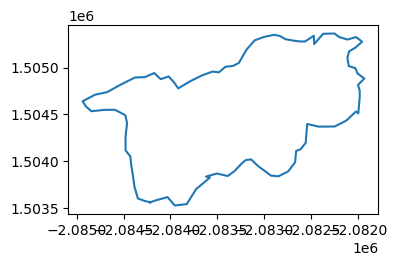

In [41]:
ws = 15
wd = 34

# Run a single simulation
